### Notebook with Python code to create figures for paper: South American Monsoon variability over the last millennium in paleoclimate records and isotope-enabled climate models.

I - Proxy network: Map of proxy records and climatology during the South American Monsoon season

II - Proxy MCEOFS: Leading two modes of variability of d18O records

III - Model eofs: Leading modes of variability from isotope-enabled climate models, compared with d18O records

IV: MCEOF interp: Interpetation of leading modes from proxy records by correlation with analogs from modern day climate


___

Rebecca Orrison 

In [3]:
#numerical computation
import numpy as np
import copy as cp 
import glob
import pandas as pd
import xarray as xr
import os.path
from eofs.xarray import Eof
import netCDF4
from scipy import signal
from scipy import ndimage
from scipy import stats
from sklearn import decomposition
from sklearn.decomposition import pca
from sklearn import preprocessing
#from statsmodels.multivariate.pca import PCA   # this is more of a climate perspective on PCA

#plotting
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cf
import matplotlib as mpl
import matplotlib.colors as cls
from matplotlib.colors import DivergingNorm
from matplotlib.gridspec import GridSpec
from matplotlib.image import imread
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
%matplotlib inline 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import proplot as plot
import seaborn as sns
import shapely.geometry as sgeom

plt.rcParams.update({'font.sans-serif':'Arial'})


/network/rit/lab/vuillelab_rit/orrison/bin/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# ------
# DEFINE FUNCTIONS FOR SUBSETTING REGIONS, plotting, etc
# ------  

In [4]:
def lat_ind_fn(latl,latu):
    return np.where((lat >= latl) & (lat <= latu))
    
def lon_ind_fn(lonl,lonu):
    return np.where((lon >= lonl) & (lon <= lonu))

def nn_idx(target,array):
    return np.abs(array - target).argmin()

def geo_loc(target,array):
    return array[np.abs(array - target).argmin()]

def EOFplot(indata,eofinput,pcinput,smoothed,variinput,title):
    """
    Plotting function to plot the first four EOFS of a dataset (usually precipitation) with expected variance.
    Inputs are the input dataset, the list of eof modes and pc modes, the variance by mode, the colorbar range use, and a title string.
    Uses a Lambert Cylindrical projection for gridded data.
    """
    gs = GridSpec(4, 3, hspace=0.25, wspace=0.2)
    fig, axs = plt.subplots(4,2, figsize=(24,24), dpi=300)
    fig.suptitle(title,size=24)
    for m in range(4):
        axs[m,0] = plt.subplot(gs[m, 0], projection=ccrs.LambertCylindrical(central_longitude=indata.lon.data[(int(len(indata.lon)/2))]))
            #set_extent(west,east,south,north)
        l = 0.1
        levels = np.arange(-1.,1.+l,l)
        im = axs[m,0].contourf(indata.lon.data, indata.lat.data, eofinput[m,:,:], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'),levels=levels)
        axs[m,0].coastlines()
        axs[m,0].add_feature(cf.BORDERS)        
        axs[m,0].set_xticks(indata.lon.data[::3], crs=ccrs.LambertCylindrical())
        axs[m,0].set_yticks(indata.lat.data[::3], crs=ccrs.LambertCylindrical())
        lon_fmt = LongitudeFormatter(number_format='.1f', degree_symbol='')
        lat_fmt = LatitudeFormatter(number_format='.1f', degree_symbol='')
        axs[m,0].xaxis.set_major_formatter(lon_fmt)
        axs[m,0].yaxis.set_major_formatter(lat_fmt)
        axs[m,0].set_aspect('auto',adjustable=None)
        axs[m,0].set_extent([indata.lon.data[0],indata.lon.data[-1],indata.lat.data[0],indata.lat.data[-1]], crs=ccrs.LambertCylindrical())        
        plt.setp(axs[m,0].get_xticklabels(),rotation=30,horizontalalignment='right')
        cbar = plt.colorbar(im,fraction=0.032, pad=0.04)
        cbar.set_label('correlation', rotation=90,fontsize=11)
        plt.title('EOF {0}'.format(m+1,variinput[m].data*100))
        plt.title('var: {1:.2f}%'.format(m+1,variinput[m].data*100), loc='right')
        plt.xlabel(r"Latitude", fontsize = 14)
        plt.ylabel(r"Longitude", fontsize = 14)

        axs[m,1] = plt.subplot(gs[m, 1:])
        axs[m,1].plot(time_axis, pcinput[:,m])
        axs[m,1].plot(time_axis, smoothed[:,m], color='blue')
        axs[m,1].axhline(y=0,c='k')
        plt.xlim(min(time_axis),max(time_axis))
        plt.xlabel("Year [CE]", fontsize = 14)


# ------
# I - Proxy network
# ------  
- Network map with DJF fraction of annual rainfall (July -- June)
- Background DJF low-level wind climatology
- Indicators of location of ITCZ, SACZ, SALLJ

In [5]:
#Data for plotting:
#---------------
# GPCP DATA (precip, land and ocean): 
#---------------
path = "/network/rit/home/ro553136/orrison/data/observations/GPCP/"
fh = xr.open_dataset(path + 'precip.DJFfracAnn_forplotting.nc')
djf_frac_avg = fh.P
lon = fh.lon
lat = fh.lat

# Era5 reanalysis:
path = "/network/rit/home/ro553136/orrison/data/reanalysis/era5/"
fhu = xr.open_dataset(path + 'era5_u_DJF_1979_2020_forplotting.nc')
fhv = xr.open_dataset(path + 'era5_v_DJF_1979_2020_forplotting.nc')
u = fhu.U
v = fhv.V
lat_U = fhu.latitude
lon_U = fhu.longitude

# Load abs values of mceof proxy data
recs = ['PAL', 'P00-H1', 'PAR', 'DV2', 'SBE3+SMT5', 'TM0', 'CR1', 'JAR', 'ALHO6', 'Boto', 'PIM4', 'MV', 'Quelccaya', 'Pumacocha']
lat_pts = [-5.92, -11.27, -4.00, -12.36, -13.81, -16.00, -24.58, -21.08, -15.20, -18.12, -11.4, -11.62, -13.93, -10.07]
lon_pts = [282.65, 284.21, 304.73, 318.43, 313.65, 313.00, 311.42, 304.42, 303.20, 294.23, 299.62, 312.51, 289.17, 283.94]
rec_dict = {'modpts': recs,'lat': lat_pts, 'lon': lon_pts}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

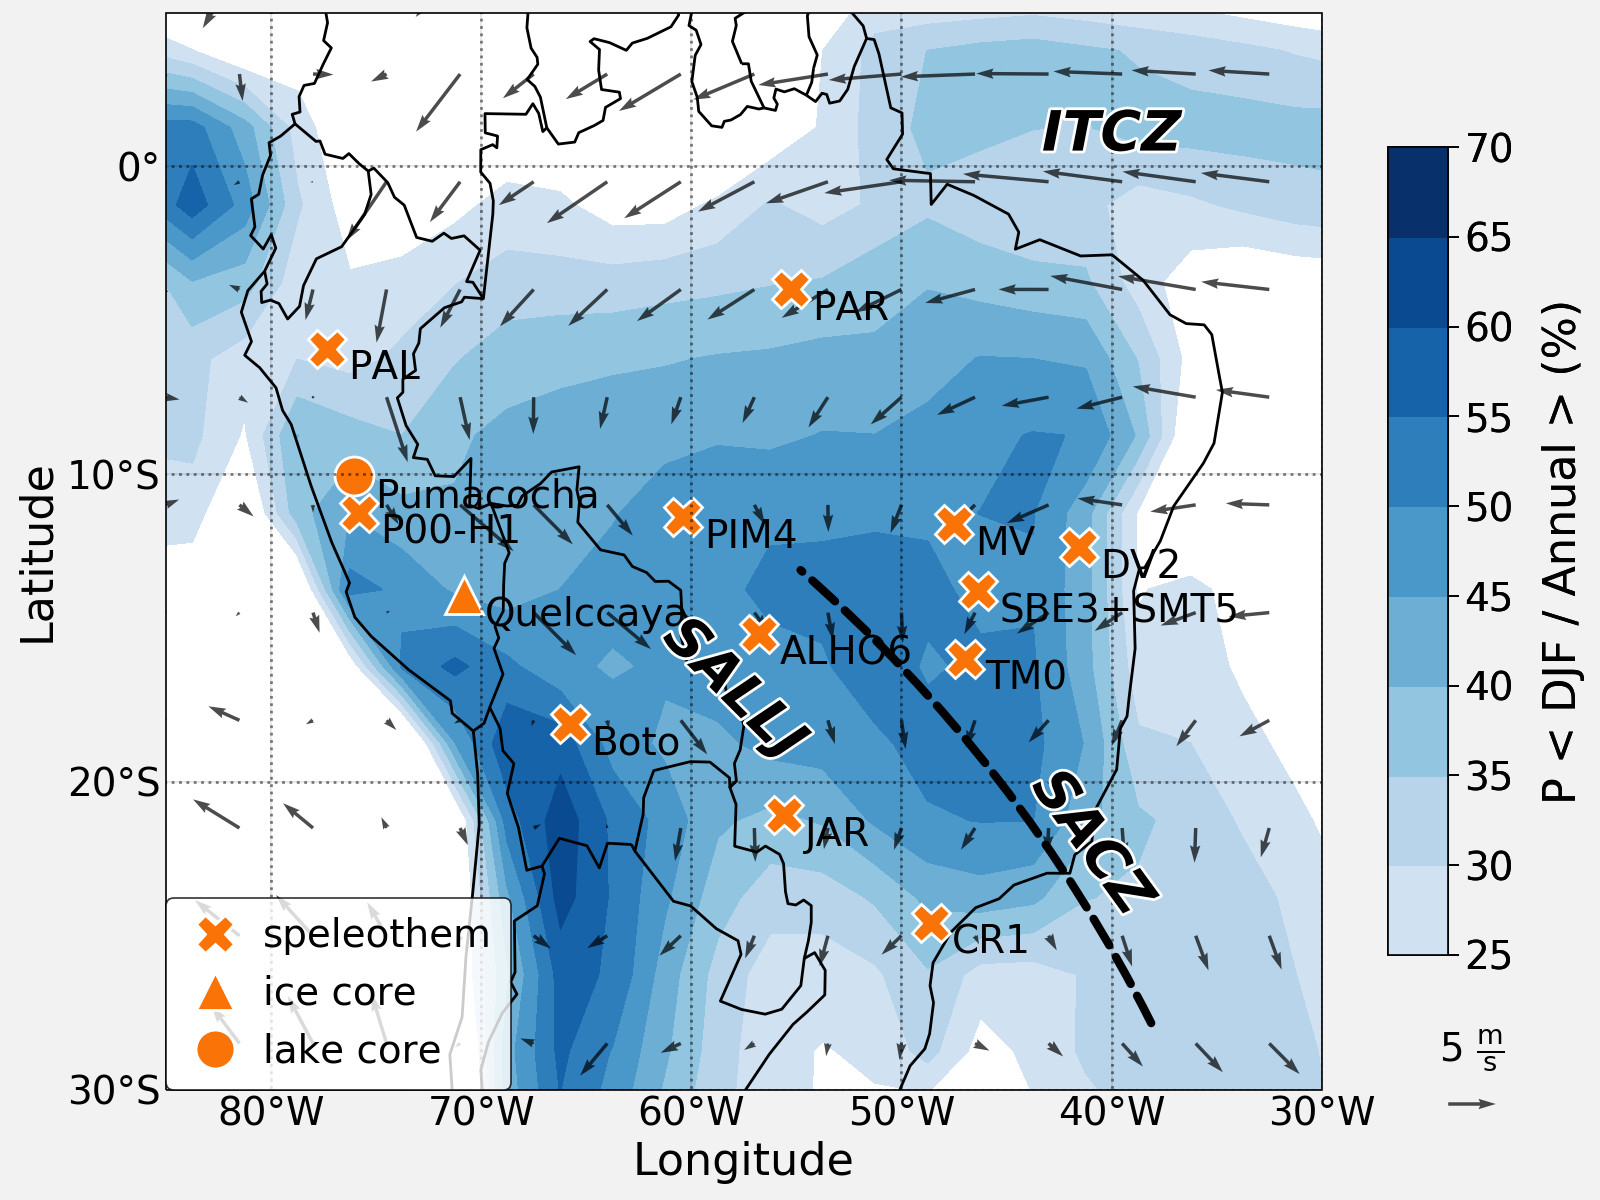

In [7]:
# PLOTTING
# pplot.rc['ytick.labelsize'] = 'large'

fig, axs = plot.subplots(proj='pcarree', figsize=(8, 6))

axs.format(land=False, labels=False, lonlines=10, latlines=10, 
           gridminor=True, 
)
fname = '/network/rit/lab/vuillelab_rit/orrison/Pictures/NE1_50M_SR_W.tif'  # high res landsurface

axs.set_aspect('auto',adjustable=None)  
axs.coastlines()
axs.add_feature(cf.BORDERS)  
axs.set_extent([330,275,5,-30], crs=ccrs.PlateCarree())
axs.set_xticks([-80,-70,-60,-50,-40,-30], crs=ccrs.PlateCarree())   
axs.set_yticks([-30,-20,-10,0], crs=ccrs.PlateCarree())
lon_fmt = LongitudeFormatter(number_format='.0f')
lat_fmt = LatitudeFormatter(number_format='.0f')
axs.xaxis.set_major_formatter(lon_fmt)
axs.yaxis.set_major_formatter(lat_fmt)
axs.set_ylabel('Latitude', fontsize=16)
axs.set_xlabel('Longitude', fontsize=16)
plt.tick_params(axis='both', labelsize=14)

cmap = plt.cm.get_cmap('Blues')

# between 0 and 1, 0 for the leftmost color of the range, 1 for the rightmost, upper > lower
upper_color = 1.0
lower_color = 0.2
num_colors =  10 # len(self.data.columns)
blues_col = cmap(np.linspace(lower_color, upper_color, num_colors))


isos = plt.contourf(lon,lat,djf_frac_avg, cmap=blues_col,levels=np.arange(25, 75, 5))
# cs = plt.contour(lon,lat,djf_frac_avg, levels=[25.0], colors='cornflowerblue')

Q = axs.quiver(lon_U[::14], lat_U[::14], u[1][::14, ::14], v[1][::14, ::14], minlength = .8, width = 0.003, transform=ccrs.PlateCarree(), alpha = 0.7)
for i,(r,lat_val,lon_val) in enumerate(zip(recs,lat_pts, lon_pts)):
    if i <= 11:
        prx_s = plt.plot(lon_val,lat_val, marker='X',linestyle = 'None', color='orange', mec='w', markersize=14, labels = 'speleothem', transform=ccrs.PlateCarree())
        txt = plt.text(lon_val + 1, lat_val - 1, r, size=14, horizontalalignment='left', transform=ccrs.PlateCarree())
        #txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
    elif i == 12:
        prx_i = plt.plot(lon_val,lat_val, marker='^',linestyle = 'None', color='orange', mec='w', markersize=14, labels = 'ice core', transform=ccrs.PlateCarree())
        txt = plt.text(lon_val + 1, lat_val - 1, r, size=14, horizontalalignment='left', transform=ccrs.PlateCarree())
        #txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
    else:
        prx_l = plt.plot(lon_val,lat_val, marker='o',linestyle = 'None', color='orange', mec='w', markersize=14, labels = 'lake core', transform=ccrs.PlateCarree())
        txt = plt.text(lon_val + 1, lat_val - 1, r, size=14, horizontalalignment='left', transform=ccrs.PlateCarree())
        #txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

axs.set_title('')
    # annotations
itcz = plt.annotate('ITCZ',xy=(-40,1),fontsize=20,weight='bold',ha='center',va='center', style='oblique',color='k')
itcz.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
sacz = plt.annotate('SACZ',xy=(-41,-22),fontsize=20,weight='bold', ha='center',va='center',style='oblique',color='k',rotation=-54)
sacz.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
plt.annotate("",xy=(-55, -13),xytext=(-38, -28),arrowprops=dict(lw=3,arrowstyle="-",linestyle = '--',color='k',connectionstyle='arc3,rad=0.1'))
sallj = plt.annotate('SALLJ',xy=(-58,-17),fontsize=20,weight='bold', ha='center',va='center', style='oblique',color='k',rotation=-45)
sallj.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

prx_all = prx_s + prx_i+prx_l
lbls = [l.get_label() for l in prx_all]
axs.legend(prx_all, lbls, loc='ll', ncol=1,fancybox=True, fontsize=14)
axs.set_ylabel('Latitude')
axs.set_xlabel('Longitude')
qk = plt.quiverkey(Q,0.92, 0.08, 5, r'$5 \,\, \frac{m}{s}$', coordinates='figure', labelsep=0.15, 
                   fontproperties = {'size':14})
cbar = plt.colorbar(isos, loc='r',length=0.75,width = .3)#, fraction=0.032, pad=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('P < DJF / Annual > (%)',fontsize=16, labelpad = 10)
fig.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/proxylocs_gpcpfrac_era5U.eps', format='eps', dpi=300, facecolor='w')
plt.show()

# ------
# II - Proxy MCEOFS:
# ------  
- Scree plot for all
- Two leading modes of d18O variability

In [8]:
#Data for plotting:
path = "/network/rit/home/ro553136/orrison/data/proxy/mceof_recs/eof_calcs/"
fh = xr.open_dataset(path + 'mceofs_Sept21_forplotting.nc')
lds = fh.lds_median
pcs = fh.pcs_median
exvar_median = fh.exvar_median
exvar_all = fh.exvar_all
err_north_all = fh.err_north_all
pcenv_min = fh.pcenv_min
pcenv_max = fh.pcenv_max

size = 1000
ages_comm = np.arange(850,1850)
ages_comm = ages_comm[::-1]

path = "/network/rit/lab/vuillelab_rit/orrison/data/CESM/iLME/"
d18O = xr.open_dataset(path + 'fullforcing/prect/b.ie12.B1850C5CN.f19_g16.LME.ensavg.cam.h0.d18O_pwt.085001-184912_djf.nc')
lat = d18O.lat
lon = d18O.lon

# Reload prox data, make sure HUA1, PUM are separated
recs = ['PAL', 'P00-H1', 'PAR', 'DV2', 'SBE3+SMT5', 'TM0', 'CR1', 'JAR', 'ALHO6', 'Boto', 'PIM4', 'MV', 'Quelccaya', 'Pumacocha']
lat_pts = [-5.92, -11.27, -4.00, -12.36, -13.81, -16.00, -24.58, -21.08, -15.20, -18.12, -11.4, -11.62, -13.93, -10.07]
lon_pts = [282.65, 284.21, 304.73, 318.43, 313.65, 313.00, 311.42, 304.42, 303.20, 294.23, 299.62, 312.51, 289.17, 283.94]

lat_pts_nn_hua = (geo_loc(lat_pts[1],lat) - (lat[1]-lat[0])).values
lat_pts[1] = lat_pts_nn_hua
rec_dict = {'modpts': recs,'lat': lat_pts, 'lon': lon_pts}

35.94% variance explained by the first two modes in median of MC iterations


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


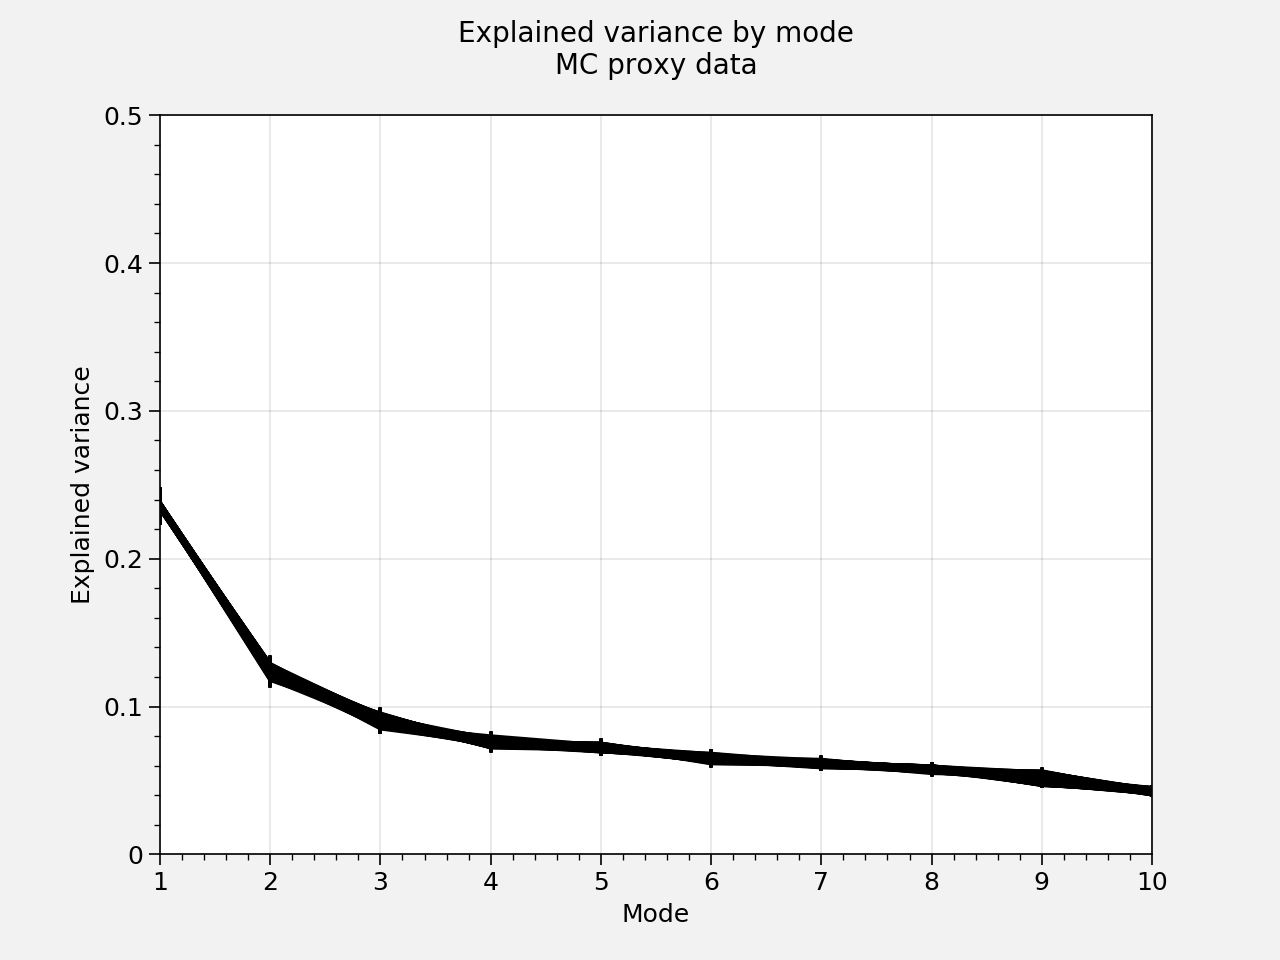

In [7]:
#----- Plot broken stick plots
print('{:.2f}% variance explained by the first two modes in median of MC iterations'.format(np.sum(exvar_median.values[0:2])*100))
    
fig,ax = plt.subplots()
for i in range(size):
    ax.errorbar(np.arange(1,11,1), exvar_all[i,:], yerr=err_north_all[i,:],color='k')
plt.title('Explained variance by mode\nMC proxy data\n')
plt.xlabel('Mode')
plt.ylabel('Explained variance')
plt.ylim(0,0.5)
# fig.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/eofs/scree_14recs_dawson_Sept21.png',dpi=300, facecolor='w')
plt.show()

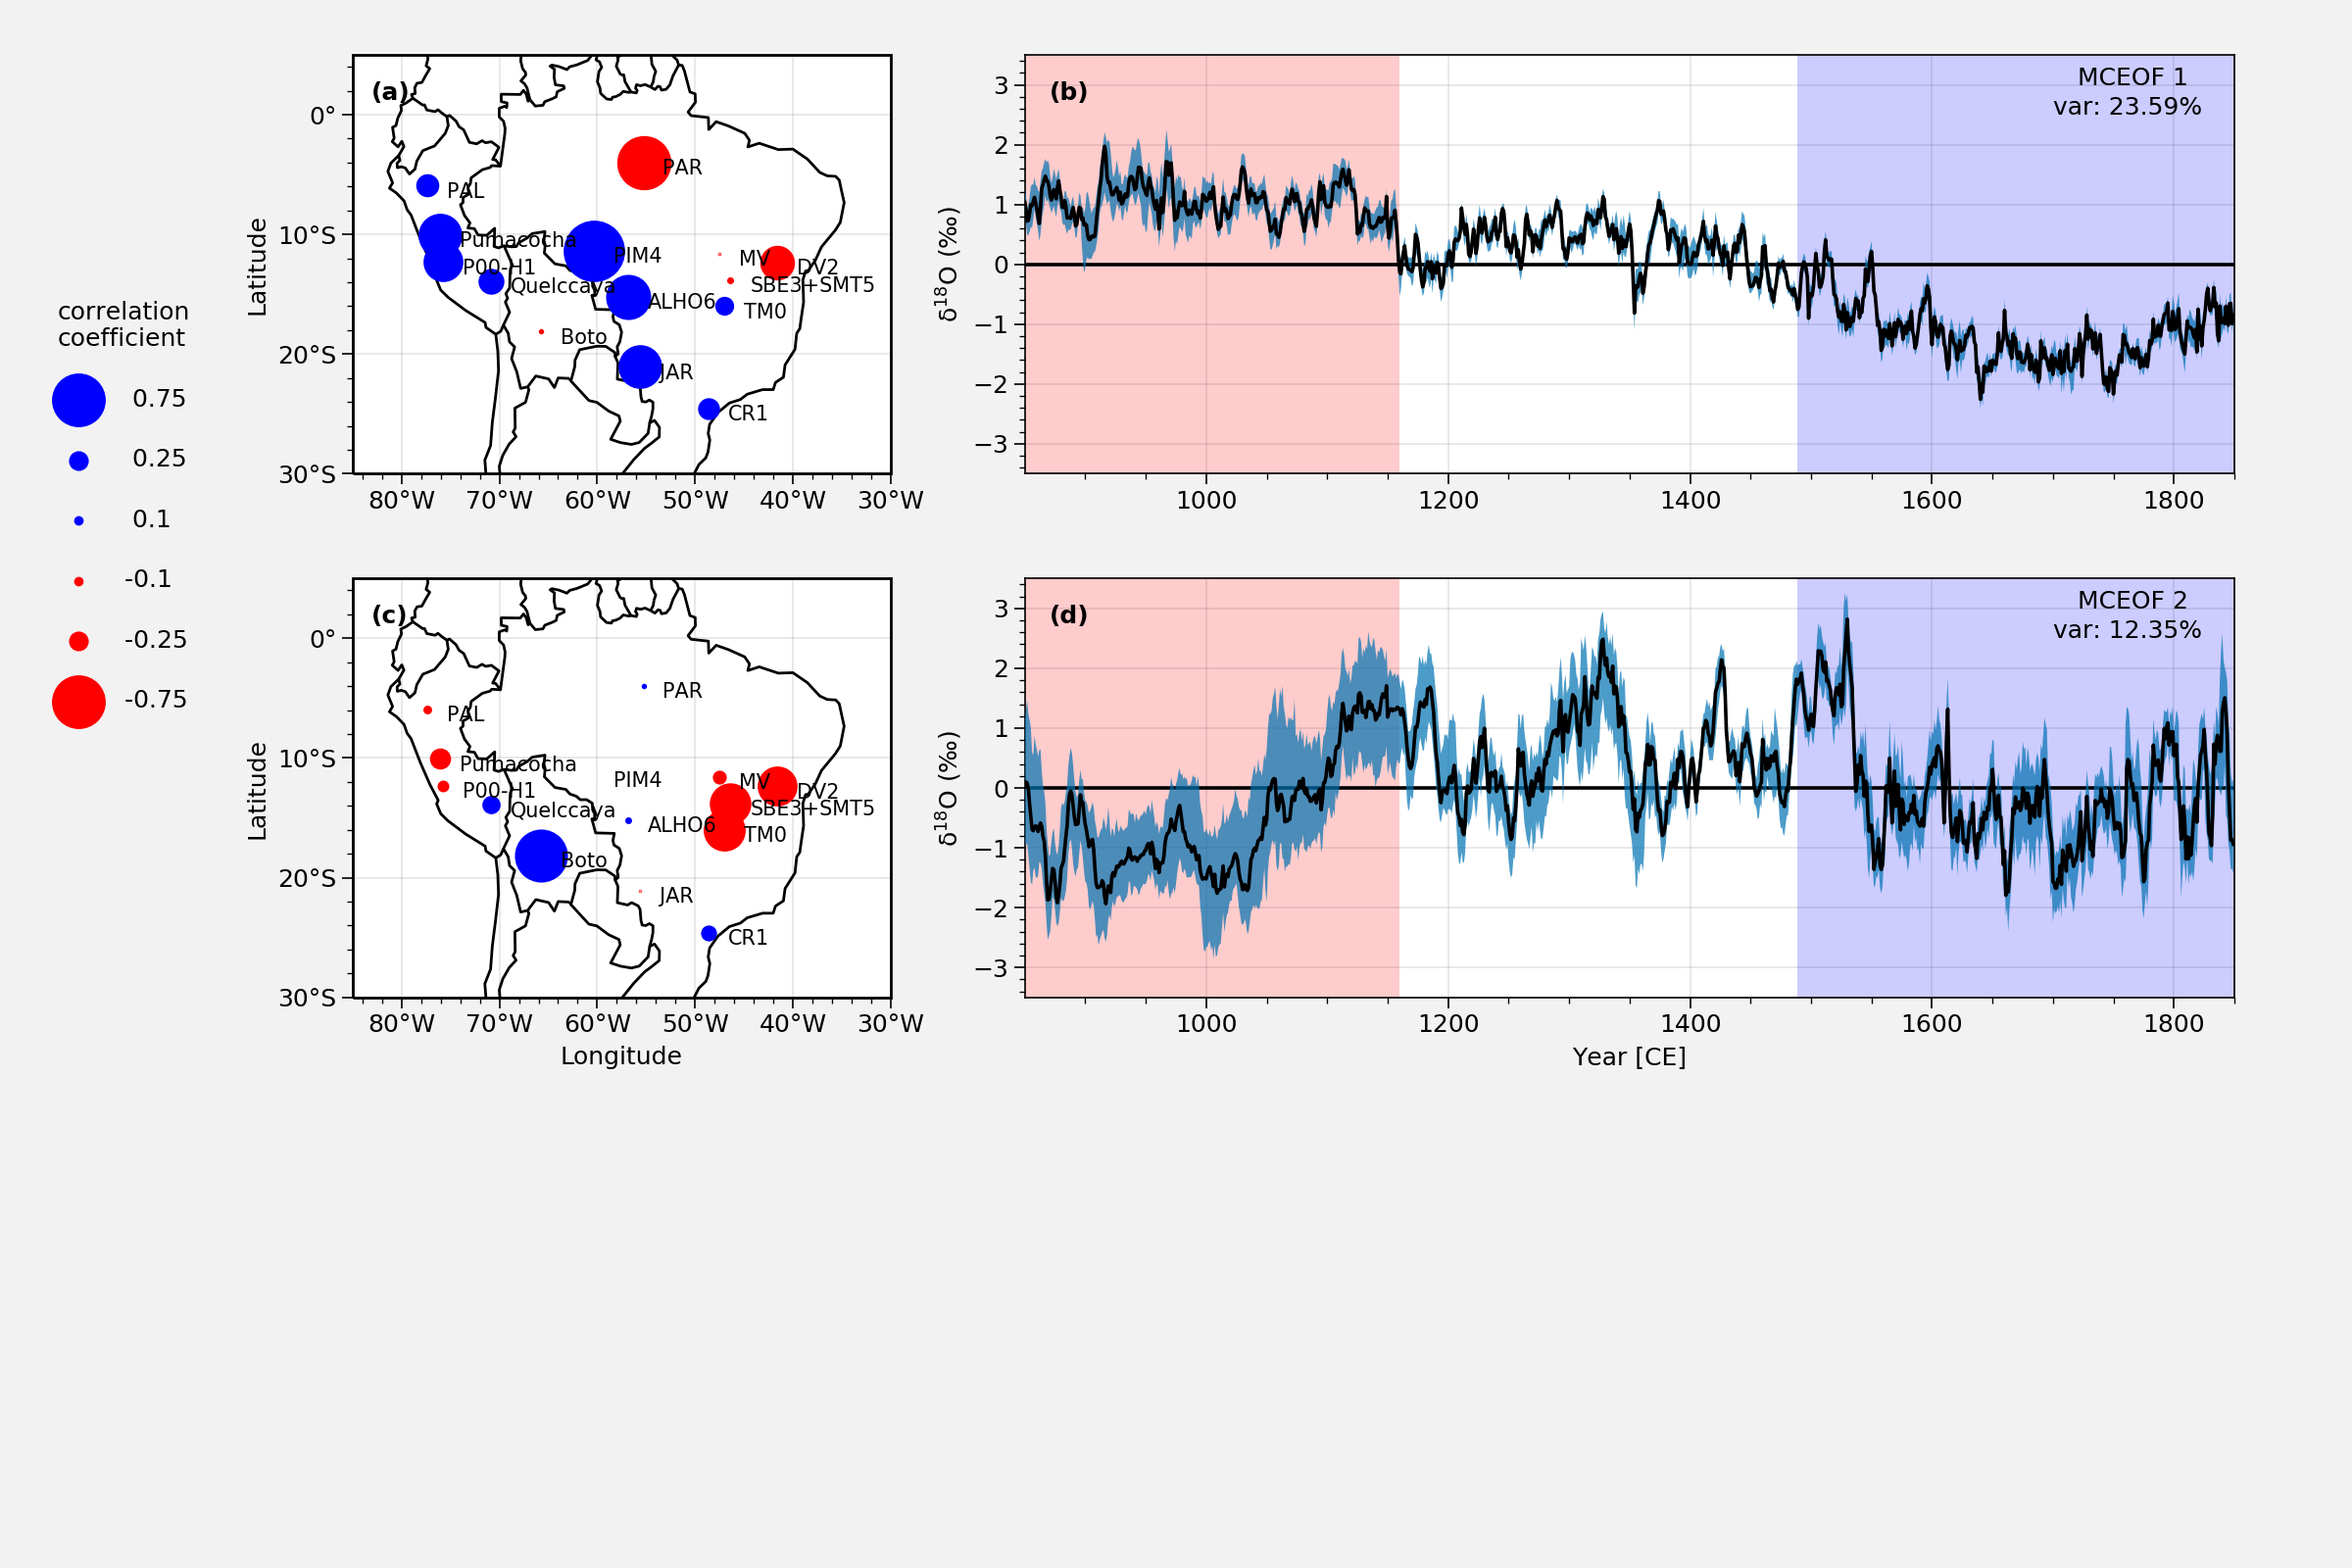

In [10]:
# ------
# Plotting proxy eofs
# ------
plt.rcParams.update({'font.sans-serif':'Arial'})

#fname = '/network/rit/lab/vuillelab_rit/orrison/Pictures/NE1_50M_SR_W.tif'  # high res landsurface

gs = GridSpec(3, 3, hspace=0.25, wspace=0.25, top=0.95, bottom=0.07)
gs.update(left=0.15,right=0.95,top=0.965,bottom=0.03)
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True,
                         figsize=(12., 8.)
                        )
figlab_s = ['(a)','(c)']
figlab_ts = ['(b)','(d)']

for m in range(2):
    axs[m,0] = plt.subplot(gs[m, 0], projection = ccrs.PlateCarree(central_longitude=len(lon/2)))
    axs[m,0].coastlines() 
    axs[m,0].add_feature(cf.BORDERS)  
    axs[m,0].set_extent([330,275,5,-30], crs=ccrs.PlateCarree())
    axs[m,0].set_xticks([-80,-70,-60,-50,-40,-30], crs=ccrs.PlateCarree())   
    axs[m,0].set_yticks([-30, -20,-10,0], crs=ccrs.PlateCarree())
    lon_fmt = LongitudeFormatter(number_format='.0f')
    lat_fmt = LatitudeFormatter(number_format='.0f')
    axs[m,0].xaxis.set_major_formatter(lon_fmt)
    axs[m,0].yaxis.set_major_formatter(lat_fmt)
    axs[m,0].set_ylabel('Latitude', fontsize='medium')
    axs[m,0].set_aspect('auto',adjustable=None)

    if m == 1:
        axs[m,0].set_xlabel('Longitude', fontsize='medium')
#     axs[m,0].text(80, 2, figlab_s[m],fontsize=20) 
#     plt.setp(axs[m,0].get_xticklabels(),horizontalalignment='right')
    s_b = plt.scatter([],[], s=(0.1*25)**2, marker='o', color='blue')
    m_b = plt.scatter([],[], s=(0.25*25)**2, marker='o', color='blue')
    l_b = plt.scatter([],[], s=(0.75*25)**2, marker='o', color='blue')
    s_r = plt.scatter([],[], s=(0.1*25)**2, marker='o', color='red')
    m_r = plt.scatter([],[], s=(0.25*25)**2, marker='o', color='red')
    l_r = plt.scatter([],[], s=(0.75*25)**2, marker='o', color='red')
    for r,lat_val,lon_val in zip(recs, lat_pts, lon_pts):
        if lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest') < 0:
            axs[m,0] = plt.plot(lon_val,lat_val, marker='o', color='red', markersize=np.abs(lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest')*25), transform=ccrs.PlateCarree())
            axs[m,0] = plt.text(lon_val + 2, lat_val - 1, r, size='small', horizontalalignment='left', transform=ccrs.PlateCarree())
        elif lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest') > 0:
            axs[m,0] = plt.plot(lon_val,lat_val, marker='o', color='blue',  markersize=lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest')*25, transform=ccrs.PlateCarree())
            axs[m,0] = plt.text(lon_val + 2, lat_val - 1, r, size='small', horizontalalignment='left', transform=ccrs.PlateCarree())
    
    axs[m,1] = plt.subplot(gs[m, 1:])
    axs[m,1].fill_between(ages_comm, pcenv_min[:,m], pcenv_max[:,m], zorder=3, alpha=0.7)  
    axs[m,1].plot(ages_comm, pcs[:,m], color='black', zorder=4)
    axs[m,1].axhline(y=0,c='k',zorder=2.6)
    axs[m,1].tick_params(axis='x', which='major', labelsize='medium')
    axs[m,1].tick_params(axis='y', which='major', labelsize='medium')
    axs[m,1].text(870, 2.75, figlab_ts[m],fontsize='medium', weight = 'bold') 
    axs[m,1].text(310, 2.75, figlab_s[m],fontsize='medium', weight = 'bold') 
    axs[m,1] = plt.text(1720, 3.0,'MCEOF '+ str(m+1),fontsize='medium') 
    axs[m,1] = plt.text(1700, 2.5,'var: {1:.2f}%'.format(m+1,exvar_median.data[m]*100),fontsize='medium') 
    plt.xlim(850,1850)  
    plt.ylim(-3.5,3.5)  
    plt.axvspan(850., 1160., facecolor='r', alpha=0.2)   # MCA (CE 724–1160)
    plt.axvspan(1489., 1850., facecolor='b', alpha=0.2)  # LIA (CE 1489–1878)
    plt.ylabel(r'$\delta^{18}O$' + u' (\u2030)', fontsize = 'medium') 
    if m == 1:
        plt.xlabel('Year [CE]', fontsize = 'medium')
    
plt.legend((l_b,m_b,s_b,s_r,m_r,l_r), ('   0.75','   0.25', '   0.1','  -0.1', '  -0.25', '  -0.75'),
           labelspacing=1.5, bbox_to_anchor=(-0.68, 0.65), fontsize = 'medium', frameon=False,
           loc = 'lower right', title='correlation\ncoefficient')
# fig.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/eofs/proxyEOFs_ann_1000iter_PCann_14recs_dawson_Sept21.eps', format='eps', dpi=300, facecolor='w')
# fig.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/eofs/proxyEOFs_ann_1000iter_PCann_14recs_dawson_Sept21.png', format='png',  dpi=300, facecolor='w')
fig.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/eofs/mceof12.png', format='png',  dpi=300, facecolor='w')


# ------
# III - Model eofs:
# ------  
- GISS/CESM full forcing
- Individual forcing runs
- White noise added eofs
- Overlaid with proxy eofs

In [9]:
# Load data
model = ['GISS-E2-R','CESM-iLME_ff','CESM-iLME_vol','CESM-iLME_sol','CESM-iLME_orb','CESM-iLME_ff_mdpts'] # 'CESM-iLME_ghg'
forcing = ['E4rhLMgTKck','fullforcing','vol','sol','orb','ff_modpts'] #'ghg'

path = "/network/rit/lab/vuillelab_rit/orrison/data/CESM/iLME/"
path_g = "/network/rit/lab/vuillelab_rit/orrison/data/GISS-E2-R/E4rhLMgTKck/"

d18O_pwt = {}
d18O_pwt["E4rhLMgTKck"] = xr.open_dataset(path_g + 'prect/GISS-E2-R.E4rhLMgTKck.d18O_pwt.0850-1849_djf.nc')
d18O_pwt["fullforcing"] = xr.open_dataset(path + 'fullforcing/prect/b.ie12.B1850C5CN.f19_g16.LME.ensavg.cam.h0.d18O_pwt.085001-184912_djf.nc')
d18O_pwt["vol"] = xr.open_dataset(path + 'vol/prect/b.ie12.B1850C5CN.f19_g16.LME.VOLC_GRA.ensavg.cam.h0.d18O_pwt.085001-184912_djf.nc')
d18O_pwt["sol"] = xr.open_dataset(path + 'sol/prect/b.ie12.B1850C5CN.f19_g16.LME.SSI_VSK_L.001.cam.h0.d18O_pwt.085001-184912_djf.nc')
d18O_pwt["orb"] = xr.open_dataset(path + 'orb/prect/b.ie12.B1850C5CN.f19_g16.LME.Orbital.001.cam.h0.d18O_pwt.085001-184912_djf.nc')

lat = d18O_pwt["fullforcing"].lat
lon = d18O_pwt["fullforcing"].lon

recs = ['PAL', 'HUA', 'PAR', 'DV2', 'SBE3+SMT5', 'TM0', 'CR1', 'JAR', 'ALHO6', 'Boto', 'PIM4', 'MV', 'Quelccaya', 'Pumacocha']
lat_pts = [-5.92, -11.27, -4.00, -12.36, -13.81, -16.00, -24.58, -21.08, -15.20, -18.12, -11.4, -11.62, -13.93, -10.07]
lon_pts = [282.65, 284.21, 304.73, 318.43, 313.65, 313.00, 311.42, 304.42, 303.20, 294.23, 299.62, 312.51, 289.17, 283.94]

lat_pts_nn_hua = (geo_loc(lat_pts[1],lat) - (lat[1]-lat[0])).values
lat_pts[1] = lat_pts_nn_hua
rec_dict = {'modpts': recs,'lat': lat_pts, 'lon': lon_pts}

# ------
# Model points
# ------  
time_axis = np.arange(851,1850)
d18O_pwt["ff_modpts"] = xr.DataArray(np.zeros([len(time_axis),len(lat),len(lon)]), dims=('time','lat','lon'),
                         coords={'time':time_axis,'lat':lat,'lon':lon},)

for i,rec in enumerate(recs):
    d18O_pwt["ff_modpts"].loc[dict(lat=lat_pts[i],lon=lon_pts[i], method='nearest')] = d18O_pwt["fullforcing"].d18O_pwt.sel(lat=lat_pts[i],lon=lon_pts[i], method='nearest')

d18O_pwt["ff_modpts"] = d18O_pwt["ff_modpts"].to_dataset(name = 'd18O_pwt')

# ------
# proxy eofs
# ------ 
path = "/network/rit/home/ro553136/orrison/data/proxy/mceof_recs/eof_calcs/"
fh = xr.open_dataset(path + 'mceofs_Sept21_forplotting.nc')
lds = fh.lds_median


In [10]:
# calculate model eofs: 
eof_dict = {}
for e,(f,m) in enumerate(zip(forcing,model)):
    d18O_pwt_a = d18O_pwt[f].d18O_pwt - d18O_pwt[f].d18O_pwt.mean(axis=0)
                # weight data by latitude
    coslat = np.cos(np.deg2rad(d18O_pwt_a.lat.values))
    wgts = np.sqrt(coslat)[...,np.newaxis]
            # preferable to pass weights to the solver, rather than apply weighting to data before computing eofs
    eof_dict[f] = Eof(d18O_pwt_a, weights=wgts,center=False)

In [11]:
# generate wnoise for analysis: {scaler: SNR} --> {2: 0.5, 4: 0.25}
# ------
d18O_pwt_a_noise = []
sclr = [2,4] 

    # Set up plotting framework: EOFS  

lat_pts_nn = [geo_loc(lat_pts[i],lat) for i in range(len(lat_pts))]
lon_pts_nn = [geo_loc(lon_pts[i],lon) for i in range(len(lon_pts))]

d18O_pwt_noise = cp.deepcopy(d18O_pwt["ff_modpts"].d18O_pwt)  
for s in sclr:
    for i in range(len(recs)):
            # standardize the data
        d18O_pwt_mdpt_std = (d18O_pwt["ff_modpts"].d18O_pwt.sel(lat=lat_pts[i], lon=lon_pts[i], method='nearest') - np.mean(d18O_pwt["ff_modpts"].d18O_pwt.sel(lat=lat_pts[i], lon=lon_pts[i], method='nearest'))) / np.std(d18O_pwt["ff_modpts"].d18O_pwt.sel(lat=lat_pts[i], lon=lon_pts[i], method='nearest'))
            # generate new white noise distribution for each model grid point, ss = 1
        pergrid_noise = np.random.normal(0, 1,999) 
            # divide wnoise by own std deviation (sd=1); multiply by sd of time series and scale to chosen SNR
        noise_scaled = (pergrid_noise * s)
        d18O_pwt_noise.loc[dict(lat=lat_pts[i],lon=lon_pts[i], method='nearest')] = d18O_pwt_mdpt_std + noise_scaled 
            # Verification
        NVAR = ((np.var(d18O_pwt_mdpt_std)) / np.var(noise_scaled))
        SNR = np.sqrt(NVAR)

    d18O_pwt_a_noise.append(d18O_pwt_noise - d18O_pwt_noise.mean(axis=0))

In [12]:
# eofs with wnoise
for j in range(len(sclr)):
    coslat = np.cos(np.deg2rad(d18O_pwt_a_noise[j].lat.values))
    wgts = np.sqrt(coslat)[...,np.newaxis]
            # preferable to pass weights to the solver, rather than apply weighting to data before computing eofs
    if j == 0:
        mdpt_eof_05 = Eof(d18O_pwt_a_noise[j], weights=wgts,center=False)
    else:
        mdpt_eof_025 = Eof(d18O_pwt_a_noise[j], weights=wgts,center=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

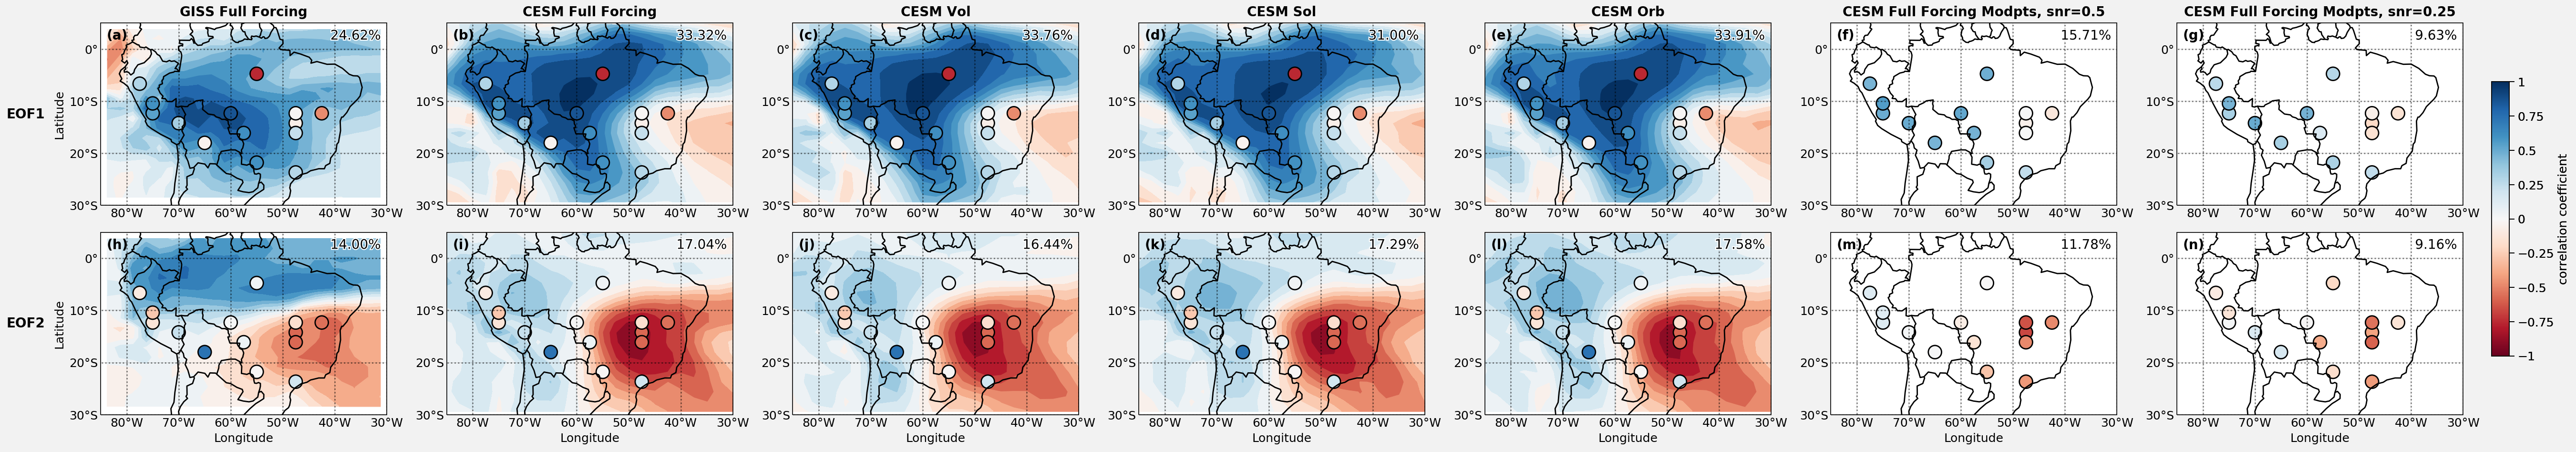

In [39]:
# corr_colors = np.arange(-1,1.25,.25)
# cb_range = np.arange(-6.5,7,1.5) # For covar
model = ['GISS-E2-R','CESM-iLME_ff','CESM-iLME_vol','CESM-iLME_sol','CESM-iLME_orb','CESM-iLME_ff_mdpts_05','CESM-iLME_ff_mdpts_025'] # 'CESM-iLME_ghg'
forcing = ['E4rhLMgTKck','fullforcing','vol','sol','orb','ff_modpts_05','ff_modpts_025']

lat_pts_nn = [geo_loc(lat_pts[i],lat) for i in range(len(lat_pts))]
lon_pts_nn = [geo_loc(lon_pts[i],lon) for i in range(len(lon_pts))]

fig, axs = plot.subplots(ncols=7, nrows=2, axwidth=3, share=3, proj='pcarree')

axs.format(land=False, labels=False, lonlines=10, latlines=10,
           share=2,
           gridminor=True, abc=True, abcloc='ul', abcstyle='(a)',
           rowlabels=['EOF1','EOF2'],
           collabels=['GISS Full Forcing','CESM Full Forcing','CESM Vol','CESM Sol','CESM Orb','CESM Full Forcing Modpts, snr=0.5','CESM Full Forcing Modpts, snr=0.25'],
)
axs.set_aspect('equal',adjustable=None)    
axs.coastlines()
axs.add_feature(cf.BORDERS) 
axs.set_extent([330,275,5,-30], crs=ccrs.PlateCarree()) 
axs.set_xticks([-80,-70,-60,-50,-40,-30], crs=ccrs.PlateCarree())   
axs.set_yticks([-30, -20,-10,0], crs=ccrs.PlateCarree())
lon_fmt = LongitudeFormatter(number_format='.0f')
lat_fmt = LatitudeFormatter(number_format='.0f')
[axs[i].xaxis.set_major_formatter(lon_fmt) for i in range(len(axs))]
[axs[i].yaxis.set_major_formatter(lat_fmt) for i in range(len(axs))]

for e,(f,m) in enumerate(zip(forcing,model)):
    # ------
    # Extract results from solver class; use covariance for the same variable.. same units. 
    # ------
    #eof_corr_cesmfull = solver.eofsAsCorrelation(neofs=30)
    
    if e < 5:
        eof_corr_mod = eof_dict[f].eofsAsCorrelation(neofs=10)
        pc_mod = eof_dict[f].pcs(npcs=10, pcscaling=1)
        vari_mod = eof_dict[f].varianceFraction(10)
        err_north_mod = eof_dict[f].northTest(neigs=10, vfscaled=True)

    elif e ==5:
        eof_corr_mdpt_05 = mdpt_eof_05.eofsAsCorrelation(neofs=10)
        pc_mdpt_05 = mdpt_eof_05.pcs(npcs=10, pcscaling=1)
        vari_mdpt_05 = mdpt_eof_05.varianceFraction(10)
        err_north_mdpt_05 = mdpt_eof_05.northTest(neigs=10, vfscaled=True)

    else: 
        eof_corr_mdpt_025 = mdpt_eof_025.eofsAsCorrelation(neofs=10)
        pc_mdpt_025 = mdpt_eof_025.pcs(npcs=10, pcscaling=1)
        vari_mdpt_025 = mdpt_eof_025.varianceFraction(10)
        err_north_mdpt_025 = mdpt_eof_025.northTest(neigs=10, vfscaled=True)

    # ------
    # Flip sign to match with d18O plts.  
    # ------
        #EOF 1
    if f == 'vol' or f == 'sol' or f == 'ff_modpts_05' or f == 'ff_modpts_025':
        eof_corr_mod[0,:,:] = eof_corr_mod[0,:,:].values*-1
        pc_mod[0] = pc_mod[0]*-1
        if e == 5:
            eof_corr_mdpt_05[0,:,:] = eof_corr_mdpt_05[0,:,:].values*-1
            pc_mdpt_05[0] = pc_mdpt_05[0].values*-1   
        if e == 6:
            eof_corr_mdpt_025[0,:,:] = eof_corr_mdpt_025[0,:,:].values*-1
            pc_mdpt_025[0] = pc_mdpt_025[0].values*-1

            #EOF 2
#     if f == 'GISS Full Forcing' or f =='CESM Full Forcing' or f == 'vol' or  'ff_modpts_05':
    if f == 'vol' or f == 'ff_modpts_05':
        eof_corr_mod[1,:,:] = eof_corr_mod[1,:,:].values*-1
        pc_mod[1] = pc_mod[1]*-1
        if e == 5:
            eof_corr_mdpt_05[1,:,:] = eof_corr_mdpt_05[1,:,:].values*-1  
            pc_mdpt_05[1] = pc_mdpt_05[1].values*-1     
#         if e == 6:
#             eof_corr_mdpt_025[1,:,:] = eof_corr_mdpt_025[1,:,:].values*-1
#             pc_mdpt_025[1] = pc_mdpt_025[1].values*-1      
    levels = np.arange(-1.,1.1,.1)

    for n in range(2):
 #         axs[m,e] = plt.subplot(projection=ccrs.LambertCylindrical(central_longitude=d18O_pwt_a.lon.data[(int(len(d18O_pwt_a.lon)/2))]))

#         im = axs[m,e].contourf(d18O_pwt_a.lon.data, d18O_pwt_a.lat.data, eof_corr_cesm[m,:,:], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'),levels=levels)
        if e < 5:
            lds_median_ls = [lds[n,:,:].sel(lat = lat_pts[i], lon = lon_pts[i],method='nearest').data for i in range(len(recs))]
            lds_model_ls = [eof_corr_mod[n,:,:].sel(lat = lat_pts[i], lon = lon_pts[i],method='nearest').data for i in range(len(recs))]

            axs[n,e].contourf(d18O_pwt_a.lon.data, d18O_pwt_a.lat.data, eof_corr_mod[n,:,:], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'),levels=levels)      
            im_dt = axs[n,e].scatter(lon_pts_nn,lat_pts_nn, c=lds_median_ls, s=100, cmap=plt.get_cmap('RdBu'), edgecolors='black', linewidth=1, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
            axs[n,e].format(title='{1:.2f}%'.format(n,vari_mod[n].data*100), titleloc='ur', abovetop=False)
        elif e == 5:
            lds_mdpt_ls_05 = [eof_corr_mdpt_05[n,:,:].sel(lat = lat_pts[i], lon = lon_pts[i],method='nearest').data for i in range(len(recs))]

            axs[n,e].scatter(lon_pts_nn,lat_pts_nn, c=lds_mdpt_ls_05, s=100, cmap=plt.get_cmap('RdBu'), edgecolors='black', linewidth=1, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
            axs[n,e].format(title='{1:.2f}%'.format(n,vari_mdpt_05[n].data*100), titleloc='ur', abovetop=False)
        else:
            lds_mdpt_ls_025 = [eof_corr_mdpt_025[n,:,:].sel(lat = lat_pts[i], lon = lon_pts[i],method='nearest').data for i in range(len(recs))]

            axs[n,e].scatter(lon_pts_nn,lat_pts_nn, c=lds_mdpt_ls_025, s=100, cmap=plt.get_cmap('RdBu'), edgecolors='black', linewidth=1, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
            axs[n,e].format(title='{1:.2f}%'.format(n,vari_mdpt_025[n].data*100), titleloc='ur', abovetop=False)

axs[:,0].set_ylabel('Latitude', fontsize='medium')
axs[1,:].set_xlabel('Longitude', fontsize='medium')
fig.colorbar(im_dt,label='correlation coefficient', loc='r',length=0.7)


plt.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/eofs/eofs_d18O_pwt_djf_mods_prox_nse_Sept21.eps', format='eps', dpi=300,facecolor='w')
plt.show()



# ------
# IV - MCEOF dynamic interp
# ------  
- MCEOF modes 1, 2 with interpretation

In [15]:
# ------
# Load data
# ------   
# load lats specifically for the lds plotting
path = "/network/rit/lab/vuillelab_rit/orrison/data/CESM/iLME/"
d18O = xr.open_dataset(path + 'fullforcing/prect/b.ie12.B1850C5CN.f19_g16.LME.ensavg.cam.h0.d18O_pwt.085001-184912_djf.nc')
lat = d18O.lat
lon = d18O.lon

ages_comm = np.arange(850,1850)
ages_comm = ages_comm[::-1]

# Reload prox data, make sure HUA1, PUM are separated
recs = ['PAL', 'P00-H1', 'PAR', 'DV2', 'SBE3+SMT5', 'TM0', 'CR1', 'JAR', 'ALHO6', 'Boto', 'PIM4', 'MV', 'Quelccaya', 'Pumacocha']
lat_pts = [-5.92, -11.27, -4.00, -12.36, -13.81, -16.00, -24.58, -21.08, -15.20, -18.12, -11.4, -11.62, -13.93, -10.07]
lon_pts = [282.65, 284.21, 304.73, 318.43, 313.65, 313.00, 311.42, 304.42, 303.20, 294.23, 299.62, 312.51, 289.17, 283.94]
lat_pts_nn_hua = (geo_loc(lat_pts[1],lat) - (lat[1]-lat[0])).values
lat_pts[1] = lat_pts_nn_hua
rec_dict = {'modpts': recs,'lat': lat_pts, 'lon': lon_pts}

recs_xpim = ['PAL', 'P00-H1', 'PAR', 'DV2', 'SBE3+SMT5', 'TM0', 'CR1', 'JAR', 'ALHO6', 'Boto', 'MV', 'Quelccaya', 'Pumacocha']
lat_pts_xpim = [-5.92, -11.27, -4.00, -12.36, -13.81, -16.00, -24.58, -21.08, -15.20, -18.12, -11.62, -13.93, -10.07]
lon_pts_xpim = [282.65, 284.21, 304.73, 318.43, 313.65, 313.00, 311.42, 304.42, 303.20, 294.23, 312.51, 289.17, 283.94]
lat_pts_nn_hua = (geo_loc(lat_pts_xpim[1],lat) - (lat[1]-lat[0])).values
lat_pts_xpim[1] = lat_pts_nn_hua
lat_pim = -11.4
lon_pim = 299.62

# MCEOF data for plotting:
path = "/network/rit/home/ro553136/orrison/data/proxy/mceof_recs/eof_calcs/"
fh = xr.open_dataset(path + 'mceofs_Sept21_forplotting.nc')
lds = fh.lds_median
pcs = fh.pcs_median
exvar_median = fh.exvar_median

    # era5 winds
wind_path = "/network/rit/home/ro553136/orrison/data/reanalysis/era5/"
era5_uv = "era5_uv_DJF_1979_2020.nc"
uv = xr.open_dataset(wind_path + era5_uv).sel(latitude=slice(5,-30))
u = np.mean(uv.u,axis=0)
u = u.assign_coords(longitude=(360 + u.longitude))
v = np.mean(uv.v,axis=0)
v = v.assign_coords(longitude=(360 + v.longitude))
ulat = u.latitude
ulon = u.longitude

    # Station Precip data
path = "/network/rit/home/ro553136/orrison/data/observations/Serano_SAm_station/SA_2deg_DJF/"
yrs = np.arange(1960,2016)
precip_stat = pd.DataFrame(yrs, columns = ['Year'])
read_files = glob.glob(path + '*_data.txt')
loc = ['ALHO6', 'Boto', 'CR1', 'DV2', 'P00-H1', 'JAR', 'MV', 'PAL', 'PAR', 'PIM4', 
       'Pumacocha', 'Quelccaya', 'SBE3+SMT5', 'TM0']

for i,f in enumerate(read_files):
    df = pd.read_csv(f, sep ='\t')
    data = df.iloc[:, 1:].median(axis=1)
    precip_stat.insert(1+i, loc[i], data)
    
    # Processed OLR Data (NOAA interpolated)
path = "/network/rit/home/ro553136/orrison/data/observations/interp_OLR/"
file = 'olr_mceof2_forplotting.nc'
olr_ds_fh = xr.open_dataset(path + file)
olr_djf_ovlp = olr_ds_fh.olr_djf_ovlp
olr_corr_sacz_l = olr_ds_fh.olr_corr_sacz_l
olr_pval_sacz_l = olr_ds_fh.olr_pval_sacz_l
olr_corr_sacz_s = olr_ds_fh.olr_corr_sacz_s
olr_pval_sacz_s = olr_ds_fh.olr_pval_sacz_s
    # PCs of sacz region
path = "/network/rit/home/ro553136/orrison/data/proxy/mceof_recs/eof_calcs/"
file = "pc_sacz_l_forplotting.nc"
fh = xr.open_dataset(path + file)
pc_sacz_l = fh.pcs_l

    # PCs of sacz region
path = "/network/rit/home/ro553136/orrison/data/proxy/mceof_recs/eof_calcs/"
file = "pc_sacz_s_forplotting.nc"
fh = xr.open_dataset(path + file)
pc_sacz_s = fh.pcs_s


/network/rit/lab/vuillelab_rit/orrison/bin/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [16]:
# Processing precip data here
# Look at the correlation of the precipitation time series to the OLR time series; 1979 -- 2015
# Missing values at PIM4: 1998, 2002, 2003, 2004
# precip data in common period
precip = precip_stat[(precip_stat.Year > 1978) & (precip_stat.Year < 2015)]
precip_xpim = precip.drop(['PIM4'], axis=1)
precip_pim = precip['PIM4'].dropna()

# OLR PC data in common period
olr_pc_sacz_xpim = pc_sacz_s[0:-5,0]

olr_pc_sacz_pim = pc_sacz_s[0:-5,0]
olr_pc_sacz_pim = olr_pc_sacz_pim.where(olr_pc_sacz_pim.time != 1998, drop=True)
olr_pc_sacz_pim = olr_pc_sacz_pim.where(olr_pc_sacz_pim.time != 2002, drop=True)
olr_pc_sacz_pim = olr_pc_sacz_pim.where(olr_pc_sacz_pim.time != 2003, drop=True)
olr_pc_sacz_pim = olr_pc_sacz_pim.where(olr_pc_sacz_pim.time != 2004, drop=True)

In [17]:
# Run correlation for MCEOF2
spatcor_sacz_xpim = {}
spatcor_sacz_pim = {}
for r in recs_xpim:
    spatcor_sacz_xpim[r] = stats.pearsonr(precip[r], olr_pc_sacz_xpim)
spatcor_sacz_pim = stats.pearsonr(precip_pim, olr_pc_sacz_pim)

#masking, p < 0.05, 95%.
#olr_corr_sig = np.where(olr_pval_sacz <= 0.1, olr_corr_sacz,np.nan) 

In [18]:
# Cosas para las plots
figlab_s = '(a)'
figlab_ts = '(b)'
lev = 0
m=0
speed = np.sqrt(u[0,:,:]**2 + v[0,:,:]**2)
lw = 5*speed / speed.max()
X,Y = np.meshgrid(ulon,ulat)


# for the mceof2 interp
lat_corners = np.array([-30.0, -10.0, -10.0, -30.0])
lon_corners = np.array([295.0, 295.0, 330.0, 330.0])
poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

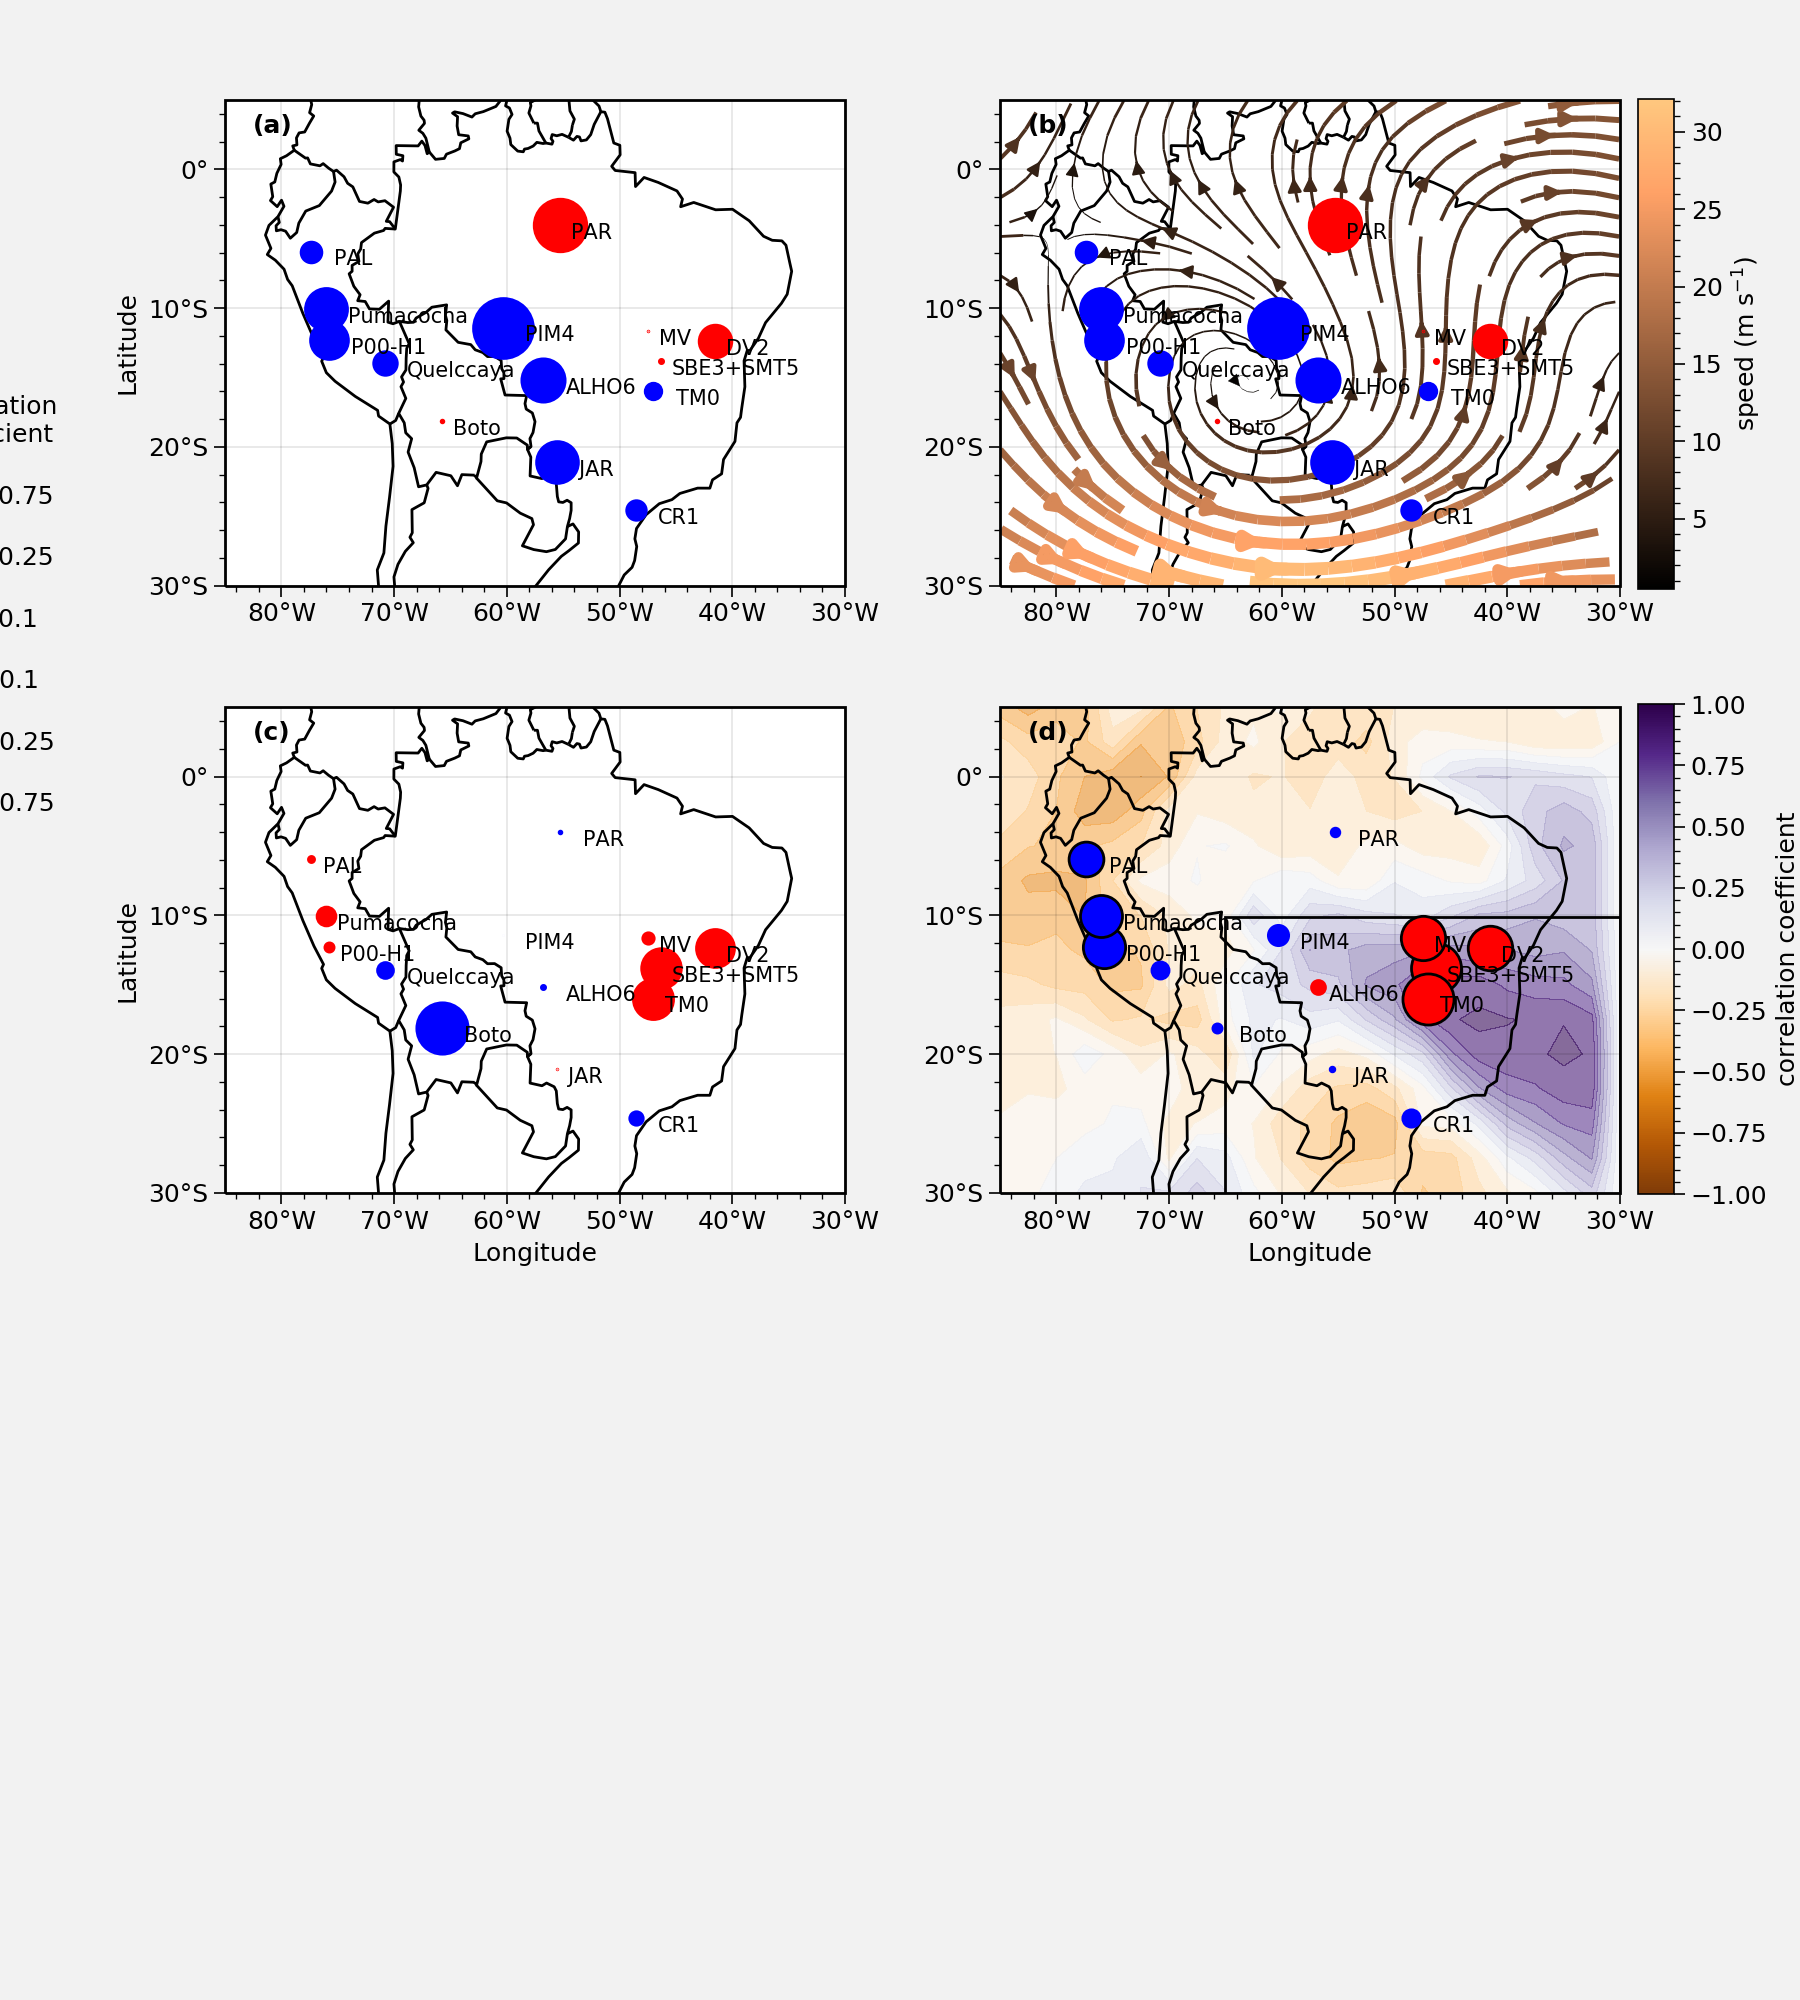

In [19]:
# levs_cor = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
levs_cor = np.arange(-1,1,.1)
# ------
# Plotting; EOF1, 200 hPa streamlines; EOF2, OLR/PRECIP relation 
# ------
            
gs = GridSpec(3, 2, hspace=0.25, wspace=0.25, top=0.95, bottom=0.1)
fig, axs = plt.subplots(2,2, figsize=(9,10))
# fig.suptitle('Proxy MCEOF1 with 200 hPa streamlines (era5; DJF, 1979-2020)', y=1.05)      
figlab_s = ['(a)','','(c)']
figlab_ts = ['','(b)','','(d)']

for i, ax in enumerate(axs.flatten()):
    ax = plt.subplot(gs[i],projection=ccrs.PlateCarree(central_longitude = lon.data[(int(len(lon)/2))]))
    ax.coastlines() 
    ax.add_feature(cf.BORDERS)        
    ax.set_extent([330,275,5,-30], crs=ccrs.PlateCarree()) 
    ax.set_xticks([-80,-70,-60,-50,-40,-30], crs=ccrs.PlateCarree())   
    ax.set_yticks([-30, -20,-10,0], crs=ccrs.PlateCarree())
    lon_fmt = LongitudeFormatter(number_format='.0f')
    lat_fmt = LatitudeFormatter(number_format='.0f')
    ax.xaxis.set_major_formatter(lon_fmt)
    ax.yaxis.set_major_formatter(lat_fmt)
    ax.set_aspect('auto',adjustable=None)
    
    s_b = plt.scatter([],[], s=(0.1*25)**2, marker='o', color='blue')
    m_b = plt.scatter([],[], s=(0.25*25)**2, marker='o', color='blue')
    l_b = plt.scatter([],[], s=(0.75*25)**2, marker='o', color='blue')
    s_r = plt.scatter([],[], s=(0.1*25)**2, marker='o', color='red')
    m_r = plt.scatter([],[], s=(0.25*25)**2, marker='o', color='red')
    l_r = plt.scatter([],[], s=(0.75*25)**2, marker='o', color='red')

    if i%2 == 0:
        ax.set_ylabel('Latitude', fontsize='medium')
        txtlab = ax.text(-25.0, 2.6, figlab_s[i],fontsize='medium', weight="bold")
        
    if i > 1 :
        ax.set_xlabel('Longitude', fontsize='medium')
    
    if i < 2:
        m = 0
        for r,lat_val,lon_val in zip(recs, lat_pts, lon_pts):
            if lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest') < 0:
                mrk = plt.plot(lon_val,lat_val, marker='o', color='red', markersize=np.abs(lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest')*25), transform=ccrs.PlateCarree())
                txt = plt.text(lon_val + 1, lat_val - 1, r, size='small', horizontalalignment='left', transform=ccrs.PlateCarree())
            elif lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest') > 0:
                mrk = plt.plot(lon_val,lat_val, marker='o', color='blue',  markersize=lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest')*25, transform=ccrs.PlateCarree())
                txt = plt.text(lon_val + 2, lat_val - 1, r, size='small', horizontalalignment='left', transform=ccrs.PlateCarree())        

    if i == 2:
        m = 1
        for r,lat_val,lon_val in zip(recs, lat_pts, lon_pts):
            if lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest') < 0:
                mrk = plt.plot(lon_val,lat_val, marker='o', color='red', markersize=np.abs(lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest')*25), transform=ccrs.PlateCarree())
                txt = plt.text(lon_val + 1, lat_val - 1, r, size='small', horizontalalignment='left', transform=ccrs.PlateCarree())
            elif lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest') > 0:
                mrk = plt.plot(lon_val,lat_val, marker='o', color='blue',  markersize=lds[m,:,:].sel(lat = lat_val, lon = lon_val,method='nearest')*25, transform=ccrs.PlateCarree())
                txt = plt.text(lon_val + 2, lat_val - 1, r, size='small', horizontalalignment='left', transform=ccrs.PlateCarree())        
      
    # Plot interpretation overlays
            
    if i == 1:
        txtlab = ax.text(-25.0, 2.6, figlab_ts[i],fontsize='medium', weight="bold") 
        strm = plt.streamplot(X,Y, u[lev,:,:].values, v[lev,:,:].values, linewidth = lw.values, density=0.9, color=speed.data,
                            cmap=plt.cm.copper, transform=ccrs.PlateCarree())  #color='grey'   
    if i == 3:
        clev = np.arange(-1.0,1.1,0.1)
        txtlab = ax.text(-25.0, 2.6, figlab_ts[i],fontsize='medium', weight="bold") 
        im = ax.contourf(olr_djf_ovlp.lon,olr_djf_ovlp.lat,olr_corr_sacz_s, cmap = 'PuOr', alpha = 0.6,
                         levels=clev, norm=DivergingNorm(0), transform=ccrs.PlateCarree())
        pval = ax.contour(olr_djf_ovlp.lon,olr_djf_ovlp.lat, olr_pval_sacz_s,levels=[0.1])
        poly = mpatches.Polygon(poly_corners, closed=True, ec='k', fill=False, lw=1, fc=None, transform=ccrs.LambertCylindrical())
        ax.add_patch(poly)
        
        for r,lat_val,lon_val in zip(recs_xpim, lat_pts_xpim, lon_pts_xpim):
            if spatcor_sacz_xpim[r][0] < 0:
                if spatcor_sacz_xpim[r][1] < 0.1:
                    mrk = plt.plot(lon_val,lat_val, marker='o', color='red', mec='k', markersize=np.abs(spatcor_sacz_xpim[r][0]*25), transform=ccrs.PlateCarree())
                    txt = plt.text(lon_val + 1, lat_val - 1, r, size= "small", horizontalalignment='left', transform=ccrs.PlateCarree())
                else:
                    mrk = plt.plot(lon_val,lat_val, marker='o', color='red', markersize=np.abs(spatcor_sacz_xpim[r][0]*25), transform=ccrs.PlateCarree())
                    txt = plt.text(lon_val + 1, lat_val - 1, r, size= "small", horizontalalignment='left', transform=ccrs.PlateCarree())
            elif spatcor_sacz_xpim[r][0] > 0:
                if spatcor_sacz_xpim[r][1] < 0.1:
                    mrk = plt.plot(lon_val,lat_val, marker='o', color='blue', mec='k', markersize=spatcor_sacz_xpim[r][0]*25, transform=ccrs.PlateCarree())
                    txt = plt.text(lon_val + 2, lat_val - 1, r, size= "small", horizontalalignment='left', transform=ccrs.PlateCarree())
                else:
                    mrk = plt.plot(lon_val,lat_val, marker='o', color='blue',  markersize=spatcor_sacz_xpim[r][0]*25, transform=ccrs.PlateCarree())
                    txt = plt.text(lon_val + 2, lat_val - 1, r, size= "small", horizontalalignment='left', transform=ccrs.PlateCarree())
        # FOR PIM
        if spatcor_sacz_pim[0] < 0:
            if spatcor_sacz_pim[1] < 0.1:
                mrk = plt.plot(lon_pim,lat_pim, marker='o', color='red', mec='k', markersize=np.abs(spatcor_sacz_pim[0]*25), transform=ccrs.PlateCarree())
                txt = plt.text(lon_pim + 1, lat_pim - 1, 'PIM4', size= "small", horizontalalignment='left', transform=ccrs.PlateCarree())
            else:
                mrk = plt.plot(lon_pim,lat_pim, marker='o', color='red', markersize=np.abs(spatcor_sacz_pim[0]*25), transform=ccrs.PlateCarree())
                txt = plt.text(lon_pim + 1, lat_pim - 1, 'PIM4', size= "small", horizontalalignment='left', transform=ccrs.PlateCarree())
        elif spatcor_sacz_pim[0] > 0:
            if spatcor_sacz_pim[1] < 0.1:
                mrk = plt.plot(lon_pim,lat_pim, marker='o', color='blue', mec='k', markersize=spatcor_sacz_pim[0]*25, transform=ccrs.PlateCarree())
                txt = plt.text(lon_pim + 2, lat_pim - 1, 'PIM4', size= "small", horizontalalignment='left', transform=ccrs.PlateCarree())
            else:
                mrk = plt.plot(lon_pim,lat_pim, marker='o', color='blue',  markersize=spatcor_sacz_pim[0]*25, transform=ccrs.PlateCarree())
                txt = plt.text(lon_pim + 2, lat_pim - 1, 'PIM4', size= "small", horizontalalignment='left', transform=ccrs.PlateCarree())

    # legends/colorbars 
corco = plt.legend((l_b,m_b,s_b,s_r,m_r,l_r), ('   0.75','   0.25', '   0.1','  -0.1', '  -0.25', '  -0.75', 'p < 0.1'),
                   labelspacing=1.5, bbox_to_anchor=(-1.5, 0.75), fontsize = 'medium', frameon=False,
                   loc = 'lower right', title='correlation\ncoefficient')

cax0 = fig.add_axes([axs[0,1].get_position().x1+0.01,axs[0,1].get_position().y0+0.1755,0.02,axs[0,1].get_position().height*0.7])
cbar0 = plt.colorbar(strm.lines, cax=cax0) # Similar to fig.colorbar(im, cax = cax)
cbar0.set_label(r'speed (m $s^{-1}$)')

my_norm = cls.Normalize(vmin=-1.0, vmax=1.0)
cmap = 'PuOr'
cax1 = fig.add_axes([axs[1,1].get_position().x1+0.01,axs[1,1].get_position().y0+0.293,0.02,axs[1,1].get_position().height*0.7])
cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=my_norm), cax=cax1) # Similar to fig.colorbar(im, cax = cax)
cbar1.set_label('correlation coefficient') 

sig = plt.scatter([],[], s=(0.5*10)**2, marker='o', facecolors='none', edgecolors='k')

fig.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/eofs/proxeof/mceofint_1_2_Sept21.eps', format='eps', dpi=300, facecolor='w', bbox_inches='tight')
